In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

In [145]:
df = pd.read_csv('minos_nh_ih/minos.3D.grid.of.sk.dm32.s2t13.s2t23.nh', names=['dm32','s2_t13','s2_t23','ji'], delim_whitespace=True)

In [288]:
def get_min_vals(df):
    
    idx_min    = df['ji'].idxmin()
    ji_min     = df['ji'][idx_min]
    dm32_min   = df['dm32'][idx_min]
    s2_t13_min = df['s2_t13'][idx_min]
    s2_t23_min = df['s2_t23'][idx_min]    
    
    return {'dm32_min':dm32_min,'s2_t13_min':s2_t13_min,'s2_t23_min':s2_t23_min,'ji_min':ji_min}

def get_normalize_data(df,minima_dic):
           
    df['ji']  = df['ji'] - minima_dic['ji_min']    
    print(minima_dic)
    
    return df

def get_data_to_plotter_1D(df,param):        
    
        dat_mins=get_min_vals(df)
        data=get_normalize_data(df,dat_mins)
        
        if(param=='dm32'):
            result = data[ ( data['s2_t13'] == dat_mins['s2_t13_min'] ) & ( data['s2_t23'] == dat_mins['s2_t23_min'] ) ]
            data = result[ ['dm32','ji'] ]
        elif(param=='s2_t13'):
            result = data[(data['dm32']   == dat_mins['dm32_min']) & (data['s2_t23'] == dat_mins['s2_t23_min'])]
            data = result[['s2_t13','ji']]
        elif(param=='s2_t23'):
            result = data[(data['dm32']   == dat_mins['dm32_min']) & (data['s2_t13'] == dat_mins['s2_t13_min'])]
            data = result[['s2_t23','ji']]
        return data
    
def get_interpolated_data_1D(df,param,size):
    
    df = get_data_to_plotter_1D(df,param)
    
    x = df[param].values
    #x=np.append(x,x[-1]*(1.1))
    
    y = df.ji.values
    #y=np.append(y,y[-1]*y[-1]*15)
    
    f1 = interpolate.interp1d(x, y, kind = 'cubic')
    x_new = np.linspace(x[0], x[-1],size)
    y_new = f1(x_new)
    data_new = pd.DataFrame({param:x_new,'ji':y_new})    
    return data_new

def get_data_to_plotter_2D(df,params):        
    
        dat_mins=get_min_vals(df)
        data=get_normalize_data(df,dat_mins)
        parameters = ['dm32','s2_t13','s2_t23']
        if ((params[0] not in parameters) or (params[1] not in parameters)): 
            print('Metiste mal los parametros a gráficas, deben ser: [dm32,s2_t13,s2_t23] ')
        else:            
            if(('dm32' in params) & ('s2_t13' in params)):                
                
                result = data[ data['s2_t23'] == dat_mins['s2_t23_min'] ]
                data   = result[ ['dm32','s2_t13','ji'] ]                
                
            elif(('dm32' in params) & ('s2_t23' in params)):

                result = data[ data['s2_t13'] == dat_mins['s2_t13_min'] ]
                data = result[ ['dm32','s2_t23','ji'] ]

            elif(('s2_t13' in params) & ('s2_t23' in params)):

                result = data[ data['dm32'] == dat_mins['dm32_min'] ]
                data = result[ ['s2_t13','s2_t23','ji'] ]

            else:
                print('La opción no existe')            
        return data

def get_interpolated_data_2D(df,params,size):
     
    df1 = get_data_to_plotter_2D(df,params)
    par =[]

    if(('dm32' in params) & ('s2_t13' in params)):
        par.append('dm32')
        par.append('s2_t13')
    elif(('dm32' in params) & ('s2_t23' in params)):            
        par.append('dm32')
        par.append('s2_t23')    
    elif(('s2_t13' in params) & ('s2_t23' in params)):
        par.append('s2_t13')
        par.append('s2_t23')
    else:
        print('La opción no existe')
        
     
    x=df1[par[0]].drop_duplicates().to_numpy()
    y=df1[par[1]].drop_duplicates().to_numpy() ###
    z=df1.ji.values                

    f = interpolate.interp2d(x, y, z, kind='cubic')

    x_new=np.linspace(x[0], x[-1],size)
    y_new=np.linspace(y[0], y[-1],size)
    z_for_my=f(x_new,y_new)
    z_for_my=z_for_my.T
    z_new=z_for_my.reshape(size*size)
    
    x=[]
    y=[]
    for i in x_new:
        for j in y_new:
            x.append(i)
            y.append(j)
    data_new = pd.DataFrame({par[0]:x,par[1]:y,'ji':z_new})      
    return data_new

# MINOS  - ( $\sin^2 \theta_{13}$, $\sin^2 \theta_{23}$, $\Delta m^2_{32}$ vs $\Delta \chi^2$)

In [260]:
def ploter_MINOS_profile(df,param,size):
    r = get_interpolated_data_1D(df,param,size)
    fig, ax = plt.subplots()
    
    ax.plot(param, 'ji', data=r,label='MINOS',c='black')
    lgnd = plt.legend(loc="upper right",fontsize=13)#, scatterpoints=1, )
    
    labels=[]    
    if(param=='dm32'):
        #ax.set_xlim(0.2, 0.8)
        #ax.set_xticks([0.2,0.4,0.6,0.8])
        #ax.set_xticklabels(['$0.2$','$0.4$','$0.6$','$0.8$'])
        
        ax.set_ylim(0, 20)   
        ax.set_yticks([0,5,10,15,20])
        ax.set_yticklabels(['$0$','$5$','$10$','$15$','$20$'])
        
        labels=[r'$\Delta m^2_{32}$',r'$\Delta \chi^2 $']
    elif(param=='s2_t13'):
        ax.set_ylim(0, 20)   
        ax.set_yticks([0,5,10,15,20])
        ax.set_yticklabels(['$0$','$5$','$10$','$15$','$20$'])
        
        labels=[r'$\sin^2 \theta_{13}$',r'$\Delta \chi^2 $']
    elif(param=='s2_t23'):
        ax.set_ylim(0, 20)   
        ax.set_yticks([0,5,10,15,20])
        ax.set_yticklabels(['$0$','$5$','$10$','$15$','$20$'])
        
        labels=[r'$\sin^2 \theta_{23}$',r'$\Delta \chi^2 $']
    else:
        print('Opción no de "param" es incorrecta')
        
    ax.tick_params(labelcolor='black', labelsize=13, width=1)
    
    ax.set(xlabel=labels[0], ylabel=labels[1])
    ax.xaxis.label.set_size(15)
    ax.yaxis.label.set_size(15)
    plt.tight_layout()
    ax.grid(True, linestyle='--')
    
    fig.savefig('images/plot_MINOS_'+param+'_vs_ji.png')
    return   

In [262]:
#ploter_MINOS_profile(df,'dm32',1000)
#ploter_MINOS_profile(df,'s2_t13',1000)
#ploter_MINOS_profile(df,'s2_t23',1000)

# MINOS  - ( 2D vs $\Delta \chi^2$)

In [388]:
def ploter_MINOS_confidence_regions(df,params,size):
    
    df = get_interpolated_data_2D(df,params,size)
    
    cl_68 = df[ (df['ji']  <=  2.30) & (df['ji']  >=  2.15) ]    
    cl_90 = df[ (df['ji']  <=  4.61) & (df['ji']  >=  4.51) ]
    
    fig, ax = plt.subplots(figsize=(9,6))
    
    par =[]
    labels = []    
    if( ('dm32' in params) & ('s2_t13' in params) ):
        par.append('s2_t13')
        par.append('dm32')        
        labels = [r'$\sin^2 \theta_{13}$',r'$\Delta m^2_{32}$'+' [eV$^2$]']        
    elif( ('dm32' in params) & ('s2_t23' in params) ):
        par.append('s2_t23')
        par.append('dm32')        
        labels = [r'$\sin^2 \theta_{23}$',r'$\Delta m^2_{32}$'+' [eV$^2$]']
        #ax.set_xlim(0.2, 0.8)
        #ax.set_xticks([0.2,0.4,0.6,0.8])
        #ax.set_xticklabels(['$0.2$','$0.4$','$0.6$','$0.8$'])
        
        ax.set_ylim(0.002, 0.0032)   
        ax.set_yticks([0.002,0.0022,0.0024,0.0026,0.0028,0.003,0.0032])
        ax.set_yticklabels(['$2.0$','$2.2$','$2.4$','$2.6$','$2.8$','$3.0$','$3.2$'])
    elif( ('s2_t13' in params) & ('s2_t23' in params) ):
        par.append('s2_t13')
        par.append('s2_t23')        
        labels = [r'$\sin^2 \theta_{13}$',r'$\sin^2 \theta_{23}$']
    else:
        print('Opción no correcta')
        
    ax.scatter(par[0], par[1], data=cl_90, c='blue',s=0.5)
    ax.scatter(par[0], par[1], data=cl_68, c='black',s=0.5)
    
    ax.set(xlabel=labels[0], ylabel=labels[1],  title='MINOS')
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    
    ax.tick_params(labelcolor='black', labelsize=13, width=1)
    
    ax.grid(True,linestyle='--')
    return

{'dm32_min': 0.0026, 's2_t13_min': 0.07, 's2_t23_min': 0.7, 'ji_min': 0.0}


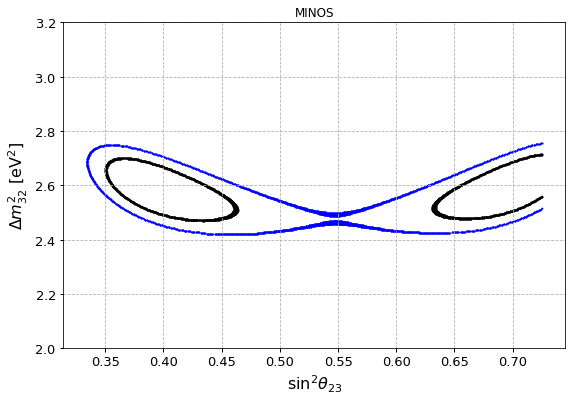

In [390]:
ploter_MINOS_confidence_regions(df,['dm32','s2_t23'],1800)
#ploter_MINOS_confidence_regions(df,['s2_t13','dm32'],1000)
#ploter_MINOS_confidence_regions(df,['s2_t23','s2_t13'],1000)